In [345]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('lag_screener_results.xlsx')

# Filter only rows with positive correlation
positive_corr_df = df[df['correlation'] > 0]

# Display the top 50 rows with positive correlation
print(positive_corr_df.head(50))


      anchor       target  lag_hr  correlation  avg_volume_usdt
12   ETHUSDT     MOVEUSDT      10      0.05431     2.662370e+07
26   SOLUSDT     MOVEUSDT      10      0.04850     2.648848e+07
28   BTCUSDT     MOVEUSDT      10      0.04655     2.649116e+07
31   SOLUSDT      GASUSDT       7      0.04530     1.229897e+07
36   ETHUSDT      IMXUSDT       3      0.04484     6.973684e+06
40   ETHUSDT      RSRUSDT       3      0.04434     9.130536e+06
61   SOLUSDT    JASMYUSDT       4      0.04182     1.260871e+07
75   ETHUSDT       MEUSDT       3      0.04037     6.309106e+06
78   BTCUSDT     NEARUSDT       8      0.04011     4.260744e+07
80   ETHUSDT    LUMIAUSDT       3      0.04000     5.311443e+06
92   BTCUSDT      NOTUSDT       8      0.03871     1.879330e+07
94   ETHUSDT      APEUSDT       3      0.03842     5.405331e+06
102  ETHUSDT      UNIUSDT       3      0.03798     5.632285e+07
106  ETHUSDT      AXSUSDT       3      0.03763     5.082829e+06
107  SOLUSDT      JSTUSDT       1      0

In [273]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

BASE_URL = "https://api.binance.com/api/v3/klines"

def fetch_ohlcv(symbol, interval='1h', start_time=None, end_time=None, limit=1000):
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit,
    }
    if start_time:
        params['startTime'] = int(start_time.timestamp() * 1000)
    if end_time:
        params['endTime'] = int(end_time.timestamp() * 1000)
    
    response = requests.get(BASE_URL, params=params)
    response.raise_for_status()
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'num_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

def download_ohlcv_range(symbol, interval, start_date, end_date):
    print(f"\n📥 Downloading {symbol} @ {interval} from {start_date.date()} to {end_date.date()}")
    
    current = start_date
    all_data = []
    
    while current < end_date:
        df = fetch_ohlcv(symbol, interval, start_time=current, end_time=end_date)
        if df.empty:
            break
        
        df = df[df['timestamp'] < end_date]
        all_data.append(df)
        
        last_timestamp = df['timestamp'].iloc[-1]
        current = last_timestamp + timedelta(hours=1)
        time.sleep(0.5)  # Respect API rate limits
    
    full_df = pd.concat(all_data).drop_duplicates(subset='timestamp')
    print(f"✅ {symbol} downloaded: {len(full_df)} rows")
    return full_df

# === Define time range: Last 6 months ===
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=180)

# === Download data for ETH and LUMIA ===
symbols = ['ETHUSDT', 'LUMIAUSDT']

for symbol in symbols:
    df = download_ohlcv_range(symbol, '1h', start_date, end_date)
    df.to_excel(f"{symbol.lower()}_1h_last6months.xlsx", index=False)

print("\n🎉 All data downloaded and saved!")



📥 Downloading ETHUSDT @ 1h from 2024-11-25 to 2025-05-24
✅ ETHUSDT downloaded: 4320 rows

📥 Downloading LUMIAUSDT @ 1h from 2024-11-25 to 2025-05-24
✅ LUMIAUSDT downloaded: 4320 rows

🎉 All data downloaded and saved!


In [274]:
import pandas as pd

# Load ETH and LUMIA 1H data
eth_1h = pd.read_excel("ethusdt_1h_last6months.xlsx", parse_dates=['timestamp'])
lumia_1h = pd.read_excel("lumiausdt_1h_last6months.xlsx", parse_dates=['timestamp'])

# Merge ETH and LUMIA on 'timestamp' with suffixes
merged = pd.merge(eth_1h, lumia_1h, on='timestamp', suffixes=('_eth', '_lumia'))

# Save merged file (optional)
merged.to_excel("merged_1h_eth_lumia_last6months.xlsx", index=False)

# Preview the merged DataFrame
print("✅ Merged ETH–LUMIA Data:")
print(merged.head())



✅ Merged ETH–LUMIA Data:
            timestamp  open_eth  high_eth  low_eth  close_eth  volume_eth  \
0 2024-11-25 09:00:00   3413.00   3483.88  3410.30    3477.56  53171.4017   
1 2024-11-25 10:00:00   3477.55   3527.00  3460.02    3500.78  61354.1293   
2 2024-11-25 11:00:00   3500.77   3507.33  3453.02    3471.84  39714.7774   
3 2024-11-25 12:00:00   3471.84   3499.72  3470.00    3482.00  24775.0569   
4 2024-11-25 13:00:00   3482.00   3495.02  3448.59    3476.38  40281.0716   

   open_lumia  high_lumia  low_lumia  close_lumia  volume_lumia  
0       1.357       1.387      1.306        1.356    1279803.01  
1       1.355       1.380      1.333        1.349     820741.35  
2       1.351       1.374      1.330        1.342     585472.24  
3       1.341       1.386      1.333        1.363     807746.53  
4       1.363       1.363      1.314        1.320     858518.19  


In [166]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged ETH + IMX 1H data
merged = pd.read_excel("merged_1h_eth_imx.xlsx", parse_dates=['timestamp'])

# Calculate 1-hour percentage returns
merged['eth_ret'] = merged['close_eth'].pct_change()
merged['imx_ret'] = merged['close_imx'].pct_change()

# Define how many lag hours to test
max_lag = 12

# Store correlations by lag
lag_correlations = {}

for lag in range(1, max_lag + 1):
    # Shift IMX returns backward (i.e., future return after ETH)
    merged[f'imx_ret_lag{lag}'] = merged['imx_ret'].shift(-lag)
    
    # Correlation between ETH return and IMX return lagged by 'lag' hours
    corr = merged[['eth_ret', f'imx_ret_lag{lag}']].corr().iloc[0, 1]
    lag_correlations[lag] = corr

# Convert to DataFrame
lag_correlations_df = pd.DataFrame(list(lag_correlations.items()), columns=['Lag (hrs)', 'Correlation'])

# Print results
print("\n📈 ETH → IMX Lag Correlations:")
print(lag_correlations_df)



📈 ETH → IMX Lag Correlations:
    Lag (hrs)  Correlation
0           1    -0.015550
1           2    -0.005871
2           3     0.040089
3           4     0.031952
4           5     0.012537
5           6    -0.018042
6           7    -0.001956
7           8     0.010439
8           9    -0.037633
9          10     0.014930
10         11    -0.010512
11         12     0.004198


In [275]:
# Save the merged ETH–LUMIA 1H data to Excel
merged.to_excel("merged_1h_eth_lumia_last6months.xlsx", index=False)
print("✅ Merged data saved to file: merged_1h_eth_lumia_last6months.xlsx")



✅ Merged data saved to file: merged_1h_eth_lumia_last6months.xlsx


In [277]:
import pandas as pd

# Load pre-merged ETH–LUMIA OHLCV data
merged = pd.read_excel("merged_1h_eth_lumia_last6months.xlsx", parse_dates=['timestamp'])

# Step 0: Calculate hourly % returns for both
merged['eth_ret'] = merged['close_eth'].pct_change()
merged['lumia_ret'] = merged['close_lumia'].pct_change()

# Step 1: ETH 1H pump trigger ≥ 1.5% (i.e., 0.015)
merged['eth_trigger'] = merged['eth_ret'] >= 0.015

# Step 2: LUMIA buy signal 3 hours later
merged['lumia_buy_signal'] = merged['eth_trigger'].shift(3)

# Step 3: Exit 3 hours after LUMIA entry
merged['lumia_exit_price'] = merged['close_lumia'].shift(-3)

# Step 4: Calculate return after entry/exit with 0.1% fees
fee = 0.001
entry_price = merged['close_lumia']
exit_price = merged['lumia_exit_price']
entry_fee = entry_price * (1 + fee)
exit_fee = exit_price * (1 - fee)
merged['lumia_return'] = (exit_fee - entry_fee) / entry_fee

# Step 5: Filter actual trades
trades = merged[merged['lumia_buy_signal'] == True].copy()
trades = trades[['timestamp', 'close_lumia', 'lumia_exit_price', 'lumia_return']].dropna()

trades.rename(columns={
    'timestamp': 'entry_time',
    'close_lumia': 'entry_price',
    'lumia_exit_price': 'exit_price',
    'lumia_return': 'return_pct'
}, inplace=True)

trades.reset_index(drop=True, inplace=True)

# Step 6: Simulate compounding portfolio
initial_capital = 10000
portfolio = [initial_capital]

for ret in trades['return_pct']:
    portfolio.append(portfolio[-1] * (1 + ret))

trades['portfolio_after'] = portfolio[1:]

# Step 7: Summary metrics
final_value = trades['portfolio_after'].iloc[-1]
total_return = (final_value - initial_capital) / initial_capital
win_rate = (trades['return_pct'] > 0).mean()
avg_return = trades['return_pct'].mean()

# Print Results
print("📈 ETH → LUMIA Lag Strategy (Fee-Adjusted)")
print(f"✅ Final Portfolio Value: ${final_value:,.2f}")
print(f"✅ Total Return: {total_return:.2%}")
print(f"✅ Number of Trades: {len(trades)}")
print(f"✅ Win Rate: {win_rate:.2%}")
print(f"✅ Avg Return per Trade: {avg_return:.4%}")

# Optional: Show sample trades
print("\n📋 Sample Trades:")
print(trades.head())



📈 ETH → LUMIA Lag Strategy (Fee-Adjusted)
✅ Final Portfolio Value: $19,107.74
✅ Total Return: 91.08%
✅ Number of Trades: 128
✅ Win Rate: 57.03%
✅ Avg Return per Trade: 0.5742%

📋 Sample Trades:
           entry_time  entry_price  exit_price  return_pct  portfolio_after
0 2024-11-25 18:00:00        1.324       1.281   -0.034410      9655.895464
1 2024-12-02 21:00:00        1.666       1.653   -0.009786      9561.407384
2 2024-12-04 03:00:00        1.705       1.730    0.012635      9682.220149
3 2024-12-04 17:00:00        1.941       2.541    0.306503     12649.853433
4 2024-12-06 03:00:00        2.194       2.202    0.001641     12670.612105


In [296]:
import pandas as pd
import numpy as np

# Load merged ETH–LUMIA data
merged = pd.read_excel("merged_1h_eth_lumia_last6months.xlsx", parse_dates=['timestamp'])

# CONFIGURATION
eth_threshold = 0.015  # 1.49% ETH pump threshold
lag = 3                 # Buy LUMIA 3 hours after ETH pump
fee = 0.001             # 0.1% entry/exit fee
initial_capital = 10000
hold_range = range(1, 7)  # Hold for 1h to 6h

# Precompute trigger and returns
merged['eth_ret'] = merged['close_eth'].pct_change()
merged['lumia_ret'] = merged['close_lumia'].pct_change()
merged['eth_trigger'] = merged['eth_ret'] >= eth_threshold
merged['lumia_buy_signal'] = merged['eth_trigger'].shift(lag)

# Store strategy performance results
results = []

for hold in hold_range:
    df = merged.copy()
    df['lumia_exit_price'] = df['close_lumia'].shift(-hold)
    
    entry_price = df['close_lumia'] * (1 + fee)
    exit_price = df['lumia_exit_price'] * (1 - fee)
    df['lumia_return'] = (exit_price - entry_price) / entry_price
    
    trades = df[df['lumia_buy_signal'] == True].copy()
    trades = trades[['timestamp', 'close_lumia', 'lumia_exit_price', 'lumia_return']].dropna()
    
    trades.rename(columns={
        'timestamp': 'entry_time',
        'close_lumia': 'entry_price',
        'lumia_exit_price': 'exit_price',
        'lumia_return': 'return_pct'
    }, inplace=True)
    
    rets = trades['return_pct'].values
    
    # Calculate annualized Sharpe Ratio
    avg_trades_per_day = len(rets) / 180
    annual_factor = np.sqrt(252 / avg_trades_per_day) if avg_trades_per_day > 0 else 0
    
    if len(rets) < 2 or np.std(rets) == 0:
        sharpe = 0.0
    else:
        sharpe = (np.mean(rets) / np.std(rets)) * annual_factor

    # Portfolio simulation
    portfolio = [initial_capital]
    for r in rets:
        portfolio.append(portfolio[-1] * (1 + r))
    
    results.append({
        'Hold (hrs)': hold,
        'Trades': len(rets),
        'Win Rate': round((rets > 0).mean(), 4),
        'Avg Return per Trade': round(np.mean(rets), 4),
        'Total Return': round((portfolio[-1] - initial_capital) / initial_capital, 4),
        'Final Portfolio': round(portfolio[-1], 2),
        'Sharpe Ratio': round(sharpe, 4)
    })

# Show best results by Total Return
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Total Return', ascending=False))



   Hold (hrs)  Trades  Win Rate  Avg Return per Trade  Total Return  \
2           3     128    0.5703                0.0057        0.9108   
3           4     128    0.5547                0.0050        0.7334   
4           5     128    0.5547                0.0048        0.6669   
1           2     128    0.5547                0.0025        0.3258   
5           6     128    0.5781                0.0027        0.2511   
0           1     128    0.5078                0.0008        0.0916   

   Final Portfolio  Sharpe Ratio  
2         19107.74        2.8260  
3         17334.04        2.5214  
4         16669.42        2.2720  
1         13258.12        1.8931  
5         12510.52        1.1713  
0         10916.42        0.9393  


In [292]:
def backtest_eth_lumia_lag_strategy(
    merged_df,
    eth_threshold=0.015,
    lag=3,
    hold=3,
    initial_capital=10000,
    fee=0.001  # 0.1% entry + 0.1% exit fee
):
    # Step 1: Calculate returns
    merged_df['eth_ret'] = merged_df['close_eth'].pct_change()
    merged_df['lumia_ret'] = merged_df['close_lumia'].pct_change()

    # Step 2: ETH pump signal
    merged_df['eth_trigger'] = merged_df['eth_ret'] > eth_threshold
    merged_df['lumia_buy_signal'] = merged_df['eth_trigger'].shift(lag)

    # Step 3: Exit price after 'hold' hours
    merged_df['lumia_exit_price'] = merged_df['close_lumia'].shift(-hold)

    # Step 4: Fee-adjusted returns
    entry_price = merged_df['close_lumia'] * (1 + fee)
    exit_price = merged_df['lumia_exit_price'] * (1 - fee)
    merged_df['lumia_return'] = (exit_price - entry_price) / entry_price

    # Step 5: Filter and rename
    trades = merged_df[merged_df['lumia_buy_signal'] == True].copy()
    trades = trades[['timestamp', 'close_lumia', 'lumia_exit_price', 'lumia_return']].dropna().reset_index(drop=True)
    trades.rename(columns={
        'timestamp': 'entry_time',
        'close_lumia': 'entry_price',
        'lumia_exit_price': 'exit_price',
        'lumia_return': 'return_pct'
    }, inplace=True)

    # Step 6: Portfolio growth
    portfolio = [initial_capital]
    for r in trades['return_pct']:
        portfolio.append(portfolio[-1] * (1 + r))
    trades['portfolio_after'] = portfolio[1:]

    # Step 7: Summary
    final_portfolio = trades['portfolio_after'].iloc[-1] if not trades.empty else initial_capital
    total_return = (final_portfolio - initial_capital) / initial_capital
    win_rate = (trades['return_pct'] > 0).mean() if not trades.empty else 0.0
    avg_return = trades['return_pct'].mean() if not trades.empty else 0.0

    result = {
        'num_trades': len(trades),
        'win_rate': win_rate,
        'avg_return': avg_return,
        'total_return': total_return,
        'final_portfolio': final_portfolio
    }

    return trades, result



In [293]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def simulate_equity_curve(trades, initial_capital=10000, title="ETH → LUMIA"):
    if trades.empty:
        print("⚠️ No trades to simulate.")
        return 0.0

    # Simulate compounded portfolio values
    equity = [initial_capital]
    for r in trades['return_pct']:
        equity.append(equity[-1] * (1 + r))
    equity = equity[1:]  # Remove duplicate of initial capital

    # Build equity DataFrame
    equity_df = trades.copy()
    equity_df['portfolio_after'] = equity
    equity_df['drawdown'] = equity_df['portfolio_after'] / equity_df['portfolio_after'].cummax() - 1

    # Metrics
    final_value = equity_df['portfolio_after'].iloc[-1]
    total_return_pct = (final_value - initial_capital) / initial_capital * 100
    max_drawdown = equity_df['drawdown'].min()

    # Sharpe Ratio (per-trade based)
    returns = equity_df['return_pct'].values
    avg_trades_per_day = len(returns) / 180  # 6 months = 180 days
    annual_factor = np.sqrt(252 / avg_trades_per_day) if avg_trades_per_day > 0 else 0
    sharpe_ratio = (
        (np.mean(returns) / np.std(returns)) * annual_factor
        if len(returns) > 1 and np.std(returns) > 0 else 0.0
    )

    # Plot equity curve
    plt.figure(figsize=(10, 5))
    plt.plot(equity_df.index, equity_df['portfolio_after'], marker='o', linewidth=2)
    plt.title(f"📈 Equity Curve — {title} (Compounded)")
    plt.xlabel("Trade #")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True)

    # Overlay metrics on the plot
    metrics_text = (
        f"Final Value   : ${final_value:,.2f}\n"
        f"Total Return  : {total_return_pct:.2f}%\n"
        f"Trades        : {len(returns)}\n"
        f"Max Drawdown  : {max_drawdown:.2%}\n"
        f"Sharpe Ratio  : {sharpe_ratio:.2f}"
    )
    plt.annotate(metrics_text, xy=(0.01, 0.01), xycoords='axes fraction',
                 fontsize=10, ha='left', va='bottom',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray"))

    plt.tight_layout()
    plt.show()

    # Print summary to console
    print(f"✅ Final Portfolio Value: ${final_value:,.2f}")
    print(f"✅ Total Return: {total_return_pct:.2f}%")
    print(f"✅ Number of Trades: {len(returns)}")
    print(f"📉 Max Drawdown: {max_drawdown:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe_ratio:.2f}")

    return max_drawdown


C:\Users\Admin\AppData\Local\Temp\ipykernel_16656\537213917.py:55: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


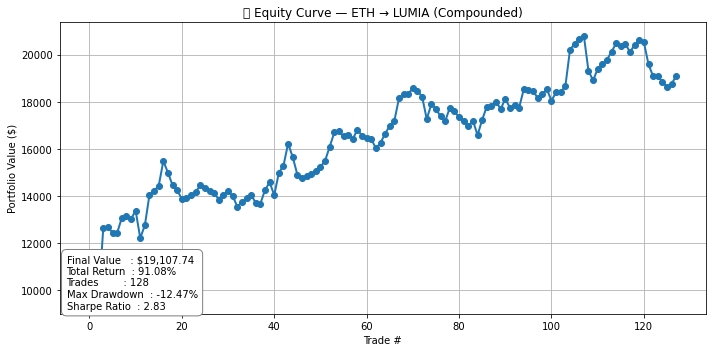

✅ Final Portfolio Value: $19,107.74
✅ Total Return: 91.08%
✅ Number of Trades: 128
📉 Max Drawdown: -12.47%
📊 Sharpe Ratio: 2.83

📊 Strategy Metrics Summary
📈 Final Portfolio Value : $19,107.74
💰 Total Return          : 91.08%
🔄 Number of Trades      : 128
🎯 Win Rate              : 57.03%
📊 Avg Return per Trade  : 0.0057
📉 Max Drawdown          : -12.47%


In [294]:
import pandas as pd

# Load merged 1H ETH + LUMIA dataset
merged = pd.read_excel("merged_1h_eth_lumia_last6months.xlsx", parse_dates=['timestamp'])

# Run lag-based ETH → LUMIA strategy backtest
trades, metrics = backtest_eth_lumia_lag_strategy(merged)

# Simulate compounded equity growth and drawdown
max_drawdown = simulate_equity_curve(trades, initial_capital=10000, title="ETH → LUMIA")

# Display summary metrics
print("\n📊 Strategy Metrics Summary")
print(f"📈 Final Portfolio Value : ${metrics['final_portfolio']:,.2f}")
print(f"💰 Total Return          : {metrics['total_return']:.2%}")
print(f"🔄 Number of Trades      : {metrics['num_trades']}")
print(f"🎯 Win Rate              : {metrics['win_rate']:.2%}")
print(f"📊 Avg Return per Trade  : {metrics['avg_return']:.4f}")
print(f"📉 Max Drawdown          : {max_drawdown:.2%}")

